# Example of use of the Concurrent_neural_network package


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from Concurrent_Neural_Network.preprocessing import filter_index_from_dataframe, compute_proportion, add_temporal_features, dataframe_to_data_loader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

## I Data

The data we use are 92400 weekly sales of 550 smartphones on CDiscount website. It has 5 columns:
 - product_id : the name of the product
 - monday_date : the monday of the week (week are taken from monday to sunday)
 - sales : number of sales of the week
 - price : average price of the week
 - margin : average relative margin of the week 


### I.A Reading Data 

In [2]:
CUR_DIR = os.getcwd()
DATA_FILE = os.path.join(CUR_DIR,'data','smartphone_data.csv' )

In [3]:
data =  pd.read_csv(DATA_FILE, sep =';')
data.set_index(['product_id', 'monday_date'], inplace= True)

### I.B Preprocess_data

We first use the function filter_index_from_dataframe to filter only the interesting products (with enough sales and enough data)

In [4]:
# filter parameters

minimal_sum=100 # A product must have at least minimal_sum to be considered
minimal_positive_length=20 # A product must have been sold during at least minimal_positive_length to be considered

In [5]:
filtered_data, products =  filter_index_from_dataframe(data, "sales", minimal_sum_target=minimal_sum )


In [6]:
print('Number of products before filter : %s' % len(set(data.index.get_level_values(0))) )
print('Number of products after filter : %s' % len(products) )
print('Number of sales before filter : %s' % sum(data['sales']))
print('Number of sales after filter : %s' % sum(filtered_data['sales']))
print('Keeped_sales_pourcentages: %.3f  ' %(100 * sum(filtered_data['sales'])/sum(data['sales'])) )

Number of products before filter : 1304
Number of products after filter : 991
Number of sales before filter : 1434188.0
Number of sales after filter : 1376327.0
Keeped_sales_pourcentages: 95.966  


We then compute the market share of the products (we scale it to 100) :

In [7]:
market_shares, weekly_global_sales, products = compute_proportion(filtered_data, 'sales', resize=1)

### I.C Exploration of the sales data

Here we present some visualisations of the data

In [8]:
# temporal feature manipulation

def format_time_index(df, index_col_name):
    adf = df.reset_index()
    adf[index_col_name] = adf[index_col_name].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))
    return adf.set_index(index_col_name)


In [9]:
f_weekly_global_sales = format_time_index(weekly_global_sales, 'monday_date')

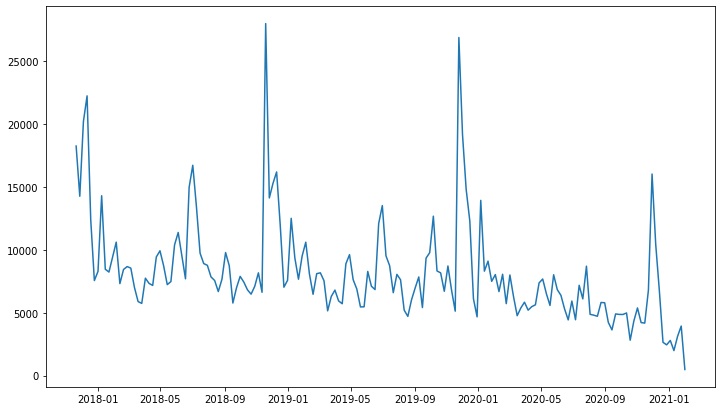

In [10]:
plt.figure(figsize=(12,7))
plt.plot(f_weekly_global_sales)
plt.show()

## II Learning

### II.A Data Learning Setting

In [11]:
#parameters
horizon = 6 #Prediction horizon
features = ['proportion_shift_6', 'proportion_shift_7','price', 'margin']
target ='proportion'
n_input = len(features)

In [12]:
data_restrained = add_temporal_features(market_shares, horizon=horizon)
data_restrained['price'] = data_restrained['price'] /100
data_restrained.head()

<ipython-input-12-70ae8a21596b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_restrained['price'] = data_restrained['price'] /100


sales     price    margin  sales_somme  proportion  \
product     monday_date                                                       
WIKOVIEWXLG 2018-01-08    14.0  2.280000  0.118202      14305.0    0.000979   
            2018-01-15     9.0  2.280000  0.118202       8458.0    0.001064   
            2018-01-22     1.0  2.215679  0.095513       8233.0    0.000121   
            2018-01-29     0.0  2.099900  0.042573       9416.0    0.000000   
            2018-02-05     0.0  2.099900  0.042573      10614.0    0.000000   

                         proportion_shift_6  proportion_shift_7  
product     monday_date                                          
WIKOVIEWXLG 2018-01-08             0.000210            0.000219  
            2018-01-15             0.000148            0.000210  
            2018-01-22             0.000315            0.000148  
            2018-01-29             0.000644            0.000315  
            2018-02-05             0.000265            0.000644

In [13]:
date_learning =  '2020-08-31'
X_train, X_test = data_restrained[data_restrained.index.get_level_values(1) < date_learning ], data_restrained[data_restrained.index.get_level_values(1) >= date_learning ]
X_train.drop(columns = ['sales_somme', 'sales'], inplace=True)
X_test.drop(columns = ['sales_somme', 'sales'], inplace=True)

/home/jupyter/.virtualenvs/rnn/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:
data_train_loader = dataframe_to_data_loader(X_train,features,target) 
data_test_loader = dataframe_to_data_loader(X_test,features,target) 

Now we present the prediction MAPE of some simple predictor :

    - null : 0
    - simple shift : predicting X_{t-h} for X_t
    - shifted 2-mean :  predicting (X_{t-h}+X_{t-h-1})/2  for X_t

Note that due to the scaling factor present on the Concurrent Neural network model they are not strictly equivalent, due to the arrival of new products. It gives however an reference

In [28]:
#Some reference_MAPE
print('Null MAPE %.2f' %   (100*sum(abs(  X_test['proportion']))/ sum(X_test['proportion'])))
print('Simple_shift MAPE %.2f' %   (100  *sum(abs(X_test['proportion_shift_6'] - X_test['proportion']))/ sum(X_test['proportion'])))
print('Simple 2-mean MAPE %.2f' %  (100  *sum(abs(X_test['proportion_shift_6']/2 + X_test['proportion_shift_7']/2 - X_test['proportion']))/ sum(X_test['proportion'])))

Null MAPE 100.00
Simple_shift MAPE 91.51
Simple 2-mean MAPE 89.73


### II.B Inner Neural Network model

Here we define the inner submodel we will use to compute the "competitiveness function"

In [15]:


class Feed_forward_model(nn.Module):
    "2 layers neural network used for for testing"

    def __init__(self, n_input, n_hidden):
        super().__init__()
        self.linear_1 = nn.Linear(n_input, n_hidden, bias=False)
        self.linear_2 = nn.Linear(n_hidden, 1, bias=False)
        self.n_input = n_input
        self.n_hidden = n_hidden

    def forward(self, x):
        return F.softplus(self.linear_2(F.relu(self.linear_1(x))), )

n_hidden = 4
submodel = Feed_forward_model(n_input,n_hidden)

### II.C Concurrent neural network

In [20]:
from Concurrent_Neural_Network.models import Concurrent_Module

learning_rate = 0.01
epochs = 100
model= Concurrent_Module(submodel, sum_factor=1, loss='L1', learning_rate =learning_rate)

In [21]:
model.train(data_train_loader,eval_dataset=data_test_loader, max_epochs=epochs, batch_print = epochs//10)

Epoch 0
Train MAPE: 91.4697
Test MAPE: 87.6324 

Epoch 10
Train MAPE: 91.3343
Test MAPE: 87.6115 

Epoch 20
Train MAPE: 91.2150
Test MAPE: 87.5427 

Epoch 30
Train MAPE: 91.1167
Test MAPE: 87.5001 

Epoch 40
Train MAPE: 91.0651
Test MAPE: 87.4643 

Epoch 50
Train MAPE: 91.0340
Test MAPE: 87.7855 

Epoch 60
Train MAPE: 90.8665
Test MAPE: 87.3517 

Epoch 70
Train MAPE: 90.8329
Test MAPE: 87.6599 

Epoch 80
Train MAPE: 90.8300
Test MAPE: 87.7231 

Epoch 90
Train MAPE: 90.8128
Test MAPE: 88.1049 

